# Breast Cancer Detection
Authors: Shreyas Kalamkar & Vijay Chaudhary

## Setting the constants

In [ ]:
config = {
    'PATH':'/content/train_new/',
    'IMAGE_SIZE':256,
    'BATCH_SIZE':32
    }

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Breast_Cancer_Detection/train_new.zip"

In [ ]:
import pandas as pd
import os
import shutil
from tqdm.notebook import tqdm as tqdm
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50,preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df = pd.read_csv('/content/drive/MyDrive/Breast_Cancer_Detection/train.csv',dtype=str)
# creating a new column filename (filename = patientId_image_id.png)
df['filename'] = ["".join([str(df['patient_id'][i]),'_',str(df['image_id'][i]),'.png']) \
                  for i in range(len(df))]
# extracting only the required columns
df = df.loc[:,['filename','cancer']]

In [ ]:
df.head()

,filename,cancer
0,10006_462822612.png,0
1,10006_1459541791.png,0
2,10006_1864590858.png,0
3,10006_1874946579.png,0
4,10011_220375232.png,0


In [ ]:
def split(df):
    x_train,x_test,y_train,y_test = train_test_split(df.filename,df.cancer,
                                                     stratify=df.cancer,
                                                     random_state=7,
                                                     test_size=0.30)
    
    train = pd.DataFrame(zip(x_train,y_train),columns=['filename','cancer'])
    test = pd.DataFrame(zip(x_test,y_test),columns=['filename','cancer'])
    
    return train,test

In [ ]:
datagen = ImageDataGenerator(preprocessing_function= preprocess_input,validation_split=0.3)

train,test = split(df)

training = datagen.flow_from_dataframe(train,
    directory=config['PATH'],
    x_col='filename',
    y_col='cancer',
    weight_col=None,
    target_size=(config['IMAGE_SIZE'], config['IMAGE_SIZE']),
    color_mode='rgb',
    class_mode='binary',
    batch_size=config['BATCH_SIZE'],
    shuffle=True,
    save_format='png',
    subset='training',
    interpolation='nearest',
    validate_filenames=True,
)

validation = datagen.flow_from_dataframe(train,
    directory=config['PATH'],
    x_col='filename',
    y_col='cancer',
    weight_col=None,
    target_size=(config['IMAGE_SIZE'], config['IMAGE_SIZE']),
    color_mode='rgb',
    class_mode='binary',
    batch_size=config['BATCH_SIZE'],
    shuffle=True,
    save_format='png',
    subset='validation',
    interpolation='nearest',
    validate_filenames=True,
)

Found 26806 validated image filenames belonging to 2 classes.
Found 11488 validated image filenames belonging to 2 classes.


In [ ]:
pretrained_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(config['IMAGE_SIZE'],config['IMAGE_SIZE'],3),
    pooling="avg",
    classes=2
)
for layer in pretrained_model.layers:
    layer.trainable = False

In [ ]:
def build_model():
    x = pretrained_model.output
    x = Flatten()(x)
    x = Dense(1024,activation = 'relu')(x)
    x = Dense(512,activation = 'relu')(x)
    x = Dropout(0.05)(x)
    out = Dense(1,activation = 'sigmoid')(x)
    model = tf.keras.Model(inputs = pretrained_model.input,outputs=out)
    return model

In [ ]:
model = build_model()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 3e-6),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits = False),
                  metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

mc = ModelCheckpoint(filepath="/content/drive/MyDrive/Breast_Cancer_Detection/model.h5",monitor="loss",verbose=1,save_best_only=True)
es = EarlyStopping(monitor='loss', min_delta = 0.001, patience=3,verbose=1)

cb = [mc,es]

In [ ]:
history = model.fit(training,
              validation_data=validation,
              epochs=10,
              callbacks=cb)

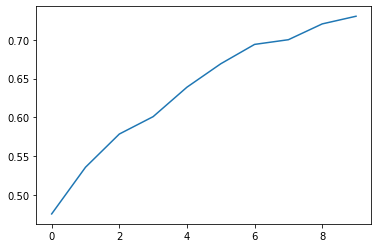

In [ ]:
plt.plot(history.history['auc'])

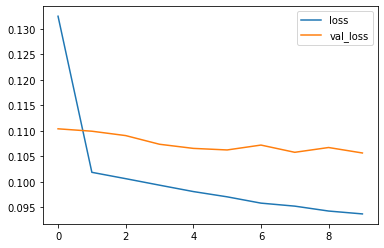

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Breast_Cancer_Detection/model.h5")
test_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

testing = test_gen.flow_from_dataframe(test,
    directory=config['PATH'],
    x_col='filename',
    y_col='cancer',
    target_size=(config['IMAGE_SIZE'], config['IMAGE_SIZE']),
    color_mode='rgb',
    class_mode='binary',
    batch_size=config['BATCH_SIZE'],
    shuffle=False,
    save_format='png',
    interpolation='nearest',
    validate_filenames=True,
)

predictions = model.predict(testing,config['BATCH_SIZE'])

Found 16412 validated image filenames belonging to 2 classes.
513/513 [==============================] - 94s 180ms/step
